In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn import preprocessing
import tensorflow as tf
from tensorflow.keras import backend as K
from tqdm import tqdm
#data setting
scan_step=10
aggregation_step=5
voltage_data_len=100
input_data_len=50
eol_threshold=100
battery_stage=100


In [2]:
#set up data processing function
def norm(data):
        a= preprocessing.StandardScaler().fit(data)
        d=a.transform(data)
        m=a.mean_
        s=a.scale_
        v=a.var_
        return d,m,s
def mish(x):
        return x * K.tanh(K.softplus(x))    

def mae(x,y):
    return np.abs(x-y).mean()
def feature_selector(model,x,norm):
    normalized_data=(np.transpose(x,(0,2,1))-norm[0])/norm[1]
    return model.predict(normalized_data,batch_size=128)
def concat_data(x1,x2,x3):
    normalized_data=(np.array(x3)-summary_norm[0])/summary_norm[1]
    return np.hstack((x1,x2,normalized_data))


def re_norm(cell_feature):
    log1=[]
    log2=[]
    for i in range(len(cell_feature)):
        len_=len(cell_feature['%d'%(i)])-eol_threshold
        for k in range(len_):
            for j in range(0,input_data_len,1):            
                log1.append(np.float32(k))
                log2.append(np.float32(eol_data[i]-k))
    log1=np.float32(norm(np.array(log1).reshape(-1,1)))[1:]
    log2=np.float32(norm(np.array(log2).reshape(-1,1)))[1:]
    return log1,log2

def process2predict(cell_feature,section):
    x_in1=[]
    x_in2=[]
    y_in1=[]
    y_in2=[]
    y_in3=[]
    for i in tqdm(range(len(cell_feature))):
        col1=[]
        col2=[]
        col3=[]
        col4=[]
        col5=[]
        len_=len(cell_feature['%d'%(i)])-eol_threshold 
        
        for k in range(0,len_,scan_step):
            for j in range(0,input_data_len,aggregation_step):
                temp=cell_feature['%d'%(i)][k:(j+k+1)]
                for stage in range(battery_stage):
                    col1.append(np.float16(np.pad(temp, ((0,input_data_len-j-1),(0,0)), 'edge')))
                    col2.append(np.float16(section[i,stage]))
                    col3.append(np.float16(battery_voltage[i,stage]))
                    col4.append(np.float16(battery_capacity[i,stage]))
                    col5.append(np.float16(battery_power[i,stage]))
                
        x_in1.append(col1)
        x_in2.append(col2)
        y_in1.append(col3)
        y_in2.append(col4)
        y_in3.append(col5)
    return x_in1,x_in2,y_in1,y_in2,y_in3

In [3]:
#loading_data
data_dir='dataset'
model_dir='pretrained'

battery_voltage = np.load('%s/battery_voltage.npy'%(data_dir),allow_pickle='TRUE')
battery_capacity = np.load('%s/battery_capacity.npy'%(data_dir),allow_pickle='TRUE')
battery_power = np.load('%s/battery_power.npy'%(data_dir),allow_pickle='TRUE')
charge_data=np.load('%s/charge_data.npy'%(data_dir),allow_pickle='TRUE').tolist()
discharge_data=np.load('%s/discharge_data.npy'%(data_dir),allow_pickle='TRUE').tolist()
summary_data=np.load('%s/summary_data.npy'%(data_dir),allow_pickle='TRUE').tolist()
charge_norm=np.load('%s/charge_norm.npy'%(data_dir),allow_pickle='TRUE').tolist()
discharge_norm=np.load('%s/discharge_norm.npy'%(data_dir),allow_pickle='TRUE').tolist()
summary_norm=np.load('%s/summary_norm.npy'%(data_dir),allow_pickle='TRUE').tolist()
eol_data = np.load('%s/battery_EoL.npy'%(data_dir),allow_pickle='TRUE')


In [4]:
#loading pre-trained model

feature_selector_ch=tf.keras.models.load_model('%s/feature_selector_ch.h5'%(model_dir), compile=False)
feature_selector_dis=tf.keras.models.load_model('%s/feature_selector_dis.h5'%(model_dir), compile=False,custom_objects={'mish':mish})
predictor=tf.keras.models.load_model('%s/predictor2.h5'%(model_dir), compile=False,custom_objects={'mish':mish})

Some of your GPUs may run slowly with dtype policy mixed_float16 because they do not all have compute capability of at least 7.0. Your GPUs:
  NVIDIA GeForce RTX 2080 Ti, compute capability 7.5
  NVIDIA GeForce GTX 1080 Ti, compute capability 6.1
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [5]:
#normalizing data
battery_voltage,voltage_mean,voltage_sacle=norm(battery_voltage.reshape(-1,voltage_data_len))
battery_capacity,capacity_mean,capacity_scale=norm(battery_capacity.reshape(-1,1))
battery_power,power_mean,power_scale=norm(battery_power.reshape(-1,1))

section=np.ones([len(battery_voltage),battery_stage])
for i in range(battery_stage):
    section[:,i]=(i+1)/battery_stage
section,section_mean,section_scale=norm(section.reshape(-1,1))

section=section.reshape(-1,battery_stage)
battery_capacity=battery_capacity.reshape(-1,battery_stage)
battery_power=battery_power.reshape(-1,battery_stage)
battery_voltage=battery_voltage.reshape(-1,battery_stage,voltage_data_len)


In [6]:
# set the prediction sample
cell_number=9     #battery id
phase=99          #which age of feature would predict
start_cycle=500   #strating cycle
append=5          #attach n cycle feature 
current_stage=int((start_cycle/(eol_data[cell_number]-eol_threshold-50))*100)


In [7]:
#feature selector & concatenate data-driven feature and Summary feature
cell_feature={}

for i in tqdm(range(len(charge_data))):
    charge_feature=feature_selector(feature_selector_ch,
                                    charge_data[i],charge_norm)
    discharge_feature=feature_selector(feature_selector_dis,
                                    discharge_data[i],discharge_norm)
    cell_feature['%d'%(i)]=concat_data(charge_feature,discharge_feature,
                               summary_data[i])    
    

x_in1,x_in2,y_in1,y_in2,y_in3=process2predict(cell_feature,section)
in_x1=np.vstack(x_in1[cell_number]).reshape(-1,input_data_len,12)
in_x2=np.vstack(x_in2[cell_number]).reshape(-1,1)

100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [03:30<00:00,  2.60s/it]


In [8]:
#Predicting and renormalize

predict_voltage,predict_capacity,predict_power=predictor.predict([in_x1,in_x2],batch_size=256)
predict_voltage=predict_voltage.reshape(-1,input_data_len//aggregation_step,battery_stage,voltage_data_len)[start_cycle//scan_step,append//aggregation_step]
predict_power=predict_power.reshape(-1,input_data_len//aggregation_step,battery_stage)[start_cycle//scan_step,append//aggregation_step]
predict_capacity=predict_capacity.reshape(-1,input_data_len//aggregation_step,battery_stage)[start_cycle//scan_step,append//aggregation_step]

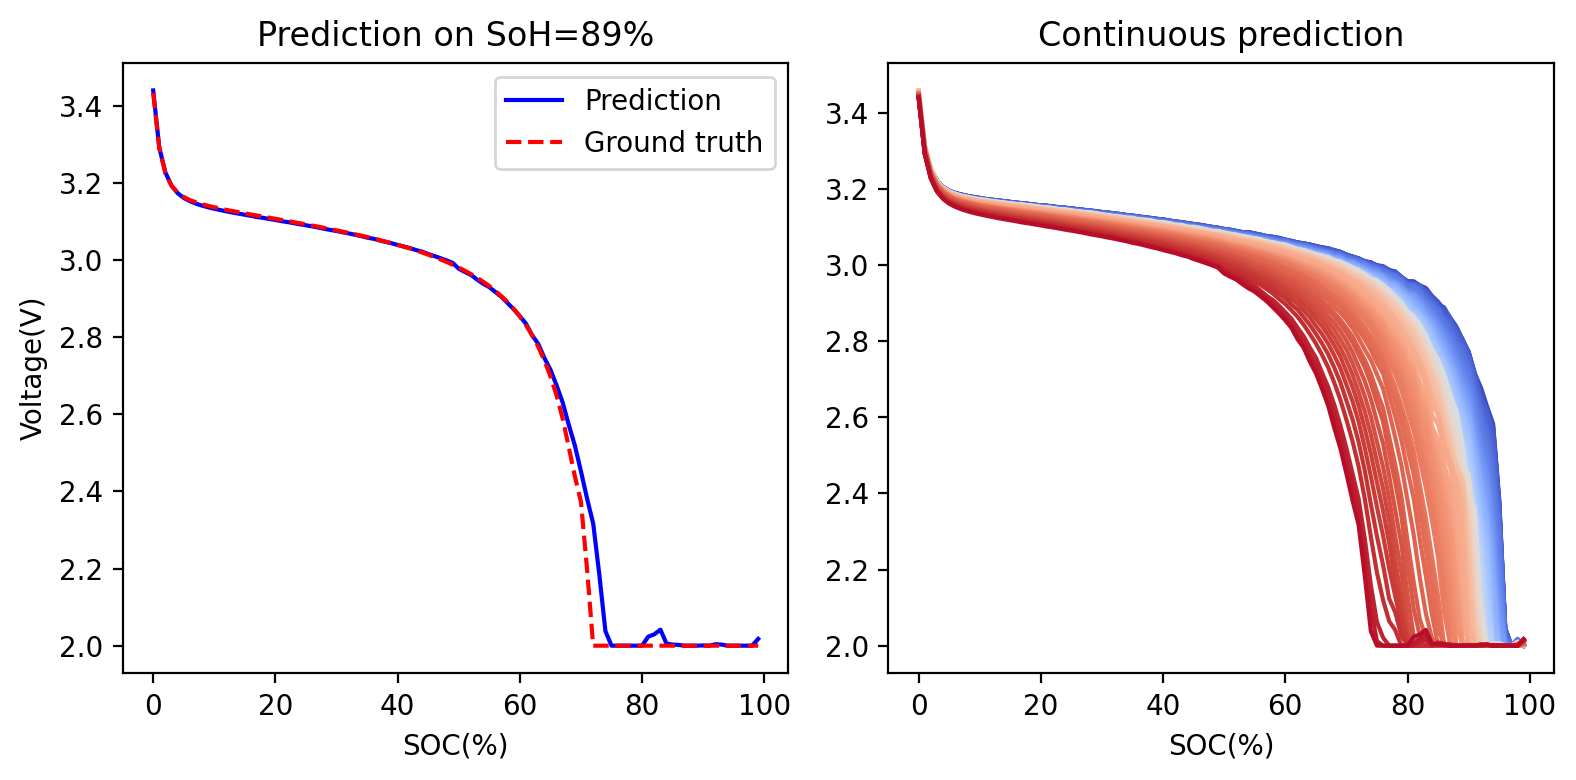

In [10]:
#plot result
def clip(x):
    return np.clip(x,2,3.6)
fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(8,4),dpi=200)

axes[0].plot(clip(predict_voltage[phase]*voltage_sacle+voltage_mean),label='Prediction',c='b')
axes[0].plot(battery_voltage[cell_number,phase]*voltage_sacle+voltage_mean,label='Ground truth'
         ,ls='--',c='r')
axes[0].legend()
axes[0].set_ylabel('Voltage(V)')
axes[0].set_xlabel('SOC(%)')
axes[1].set_xlabel('SOC(%)')

cm=plt.get_cmap('coolwarm')
for i in range(battery_stage):
    axes[1].plot(clip(predict_voltage[i]*voltage_sacle+voltage_mean),c=cm(i/battery_stage))
axes[0].set_title('Prediction on SoH=%d%%'%(int((battery_capacity[cell_number]*capacity_scale+capacity_mean)[current_stage]*100)))
axes[1].set_title('Continuous prediction')

plt.tight_layout() 

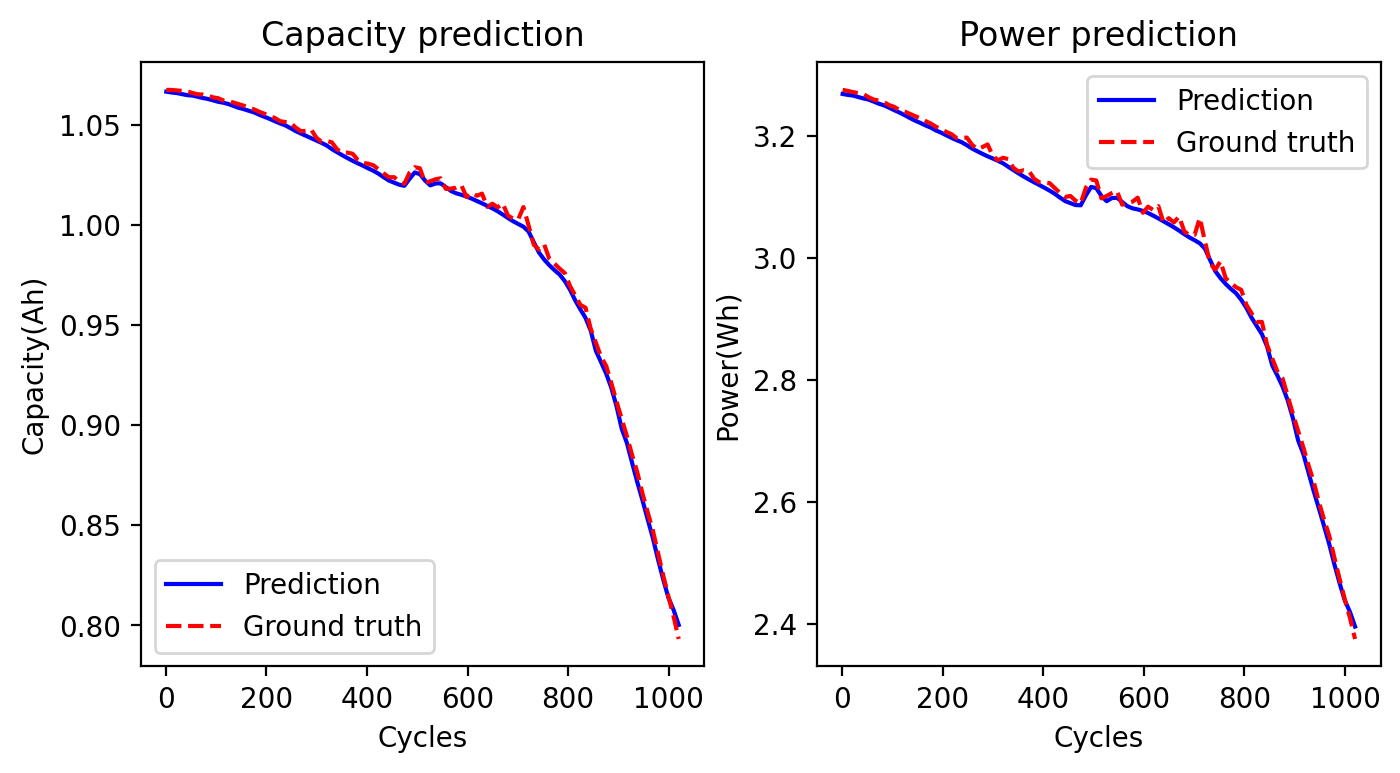

In [11]:
fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(8,4),dpi=200)
target_eol=len(x_in1[cell_number])/5/100*10

axes[0].plot(np.linspace(1,target_eol,100),predict_capacity*capacity_scale+capacity_mean,c='b'
             ,label='Prediction')
axes[0].plot(np.linspace(1,target_eol,100),battery_capacity[cell_number]*capacity_scale+capacity_mean,
             ls='--',c='r',label='Ground truth')


axes[1].plot(np.linspace(1,target_eol,100),predict_power*power_scale+power_mean,c='b'
             ,label='Prediction')
axes[1].plot(np.linspace(1,target_eol,100),battery_power[cell_number]*power_scale+power_mean,
             ls='--',c='r',label='Ground truth')
axes[0].set_title('Capacity prediction')
axes[1].set_title('Power prediction')
axes[0].set_xlabel('Cycles')
axes[1].set_xlabel('Cycles')

axes[0].set_ylabel('Capacity(Ah)')
axes[1].set_ylabel('Power(Wh)')
axes[0].legend()
axes[1].legend()